_**Sandbox Figure 6**_

# Annual Change in HRRR and MesoWest Percentile Statistics
MesoWest percentile calculations retreived from MesoWest API
HRRR percentile calculations generated by the OSG

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new

/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/h5py-2.7.0rc2-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 6.5
one_column = 3.5
twothird_column = 5.5
mpl.rcParams['figure.figsize'] = [two_column, 3.5]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .2
mpl.rcParams['grid.alpha'] = .8
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # print
#mpl.rcParams['savefig.dpi'] = 300    # print
#mpl.rcParams['savefig.dpi'] = 72     # web

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


## Get lat/lon grid from file to pluck point from HRRR OSG dataset

In [3]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group8/blaylock/HRRR_OSG/hourly30/'
latlon_file = h5py.File(DIR+'HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

## Functions: Get a point from the OSG percentile grid

In [4]:
def get_point_MP(inputs):
    """
    Function for MultiProcessing:
    Return the value from a point in the HDF5 file array
    """
    FILE, STAT, ROW, COL = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT][ROW][COL]
    except:
        #print "COULD NOT GET", FILE
        return np.nan

def get_point_COUNTS_MP(inputs):
    """
    Function for MultiProcessing:
    Return the value from a point in the HDF5 file array
    """
    FILE = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f['count'].value
    except:
        #print "COULD NOT GET", FILE
        return np.nan

-------

### Input Arguments
statistic can be from the list:  
`mean, p00, p01, p02, p03, p04, p05, p10, p15, p25, p33, p50, p66, p75, p90, p95, p96, p97, p98, p99, p100`

In [61]:
percentiles = [5, 25, 50, 75, 95]
var = 'TMP:2 m'
stn = 'KSLC'
fxx = 0
hour = 18

# Period of interest
sDATE = datetime(2016, 1, 1)
eDATE = datetime(2017, 1, 1)

##### Additional Setup

In [62]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group8/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

if var == 'TMP:2 m':
    MWvar = 'air_temp'
    label = '2 m Temperature (C)'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
    label = '2 m Dew Point Temperature (C)'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
    label = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'UVGRD:80 m':
    MWvar = 'wind_speed'
    label = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
else:
    MWvar = ''
    print "NO MATCHING VAR AND MESOWEST VAR"

if (eDATE-sDATE).days < 365:
    months = np.arange(sDATE.month,eDATE.month+1)
else:
    months = np.arange(1,13)

days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Dates (with leap year)
DATES = np.array([datetime(2016, sDATE.month, sDATE.day, hour) + timedelta(days=d) for d in range((eDATE-sDATE).days)])


# Plot Window (convert needs to be a leap year, so use 2016)
if (eDATE-sDATE).days >=365:
    sPLOT = datetime(2016, sDATE.month, sDATE.day, sDATE.hour)
    ePLOT = datetime(2017, eDATE.month, eDATE.day, eDATE.hour)
else:
    sPLOT = datetime(2016, sDATE.month, sDATE.day, sDATE.hour)
    ePLOT = datetime(2016, eDATE.month, eDATE.day, eDATE.hour)

## Get HRRR Percentiles
From the OSG files

In [63]:
# Get Time Series Data for each requested Statistic
# HTS is the HRRR-statistic Time Series

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)

print "Station:\t", stn
print "Grid Point:\t", point[0][0], point[1][0]
print "Variable:\t", var, 'and', MWvar

# HRRR Percentile Time Series
HTS = OrderedDict()
for i, pp in enumerate(percentiles):
    # Multiprocessing :)
    stat = 'p%02d' % pp
    args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, D.month, D.day, D.hour), stat, point[0][0], point[1][0]] for D in DATES]
    timer = datetime.now()
    num_proc = multiprocessing.cpu_count()
    p = multiprocessing.Pool(num_proc)
    HTS[stat] = np.array(p.map(get_point_MP, args))
    p.close()
    
    if var == 'TMP:2 m':
        HTS[stat] = HTS[stat]-273.15
        ylabel = '2 m Temperature (C)'
        ylim = [-20, 40]
    elif var == 'DPT:2 m':
        HTS[stat] = HTS[stat]-273.15
        ylabel = '2 m Dew Point (C)'
        ylim = [-20, 20]
    elif var == 'UVGRD:10 m':
        ylabel = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
        ylim = [0, 12]
    elif var == 'UVGRD:80 m':
        ylabel = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
    elif var == 'REFC:entire':
        ylabel = 'Simulated Composite Reflecivity (dBZ)'
    elif var == 'HGT:500':
        ylabel = 'Geopotential Height (m)'
    print "%s Timer:%s" % (stat, datetime.now()-timer)

Station:	KSLC
Grid Point:	645 494
Variable:	TMP:2 m and air_temp
p05 Timer:0:00:00.374917
p25 Timer:0:00:00.381365
p50 Timer:0:00:00.387555
p75 Timer:0:00:00.395595
p95 Timer:0:00:00.380280


## Get MesoWest Percentiles
From MesoWest API

In [64]:
MW_per = get_mesowest_percentiles(stn, variable=MWvar, percentiles=percentiles, v=True)
print 'MesoWest Station: %s \t Variable: %s' % (stn, MWvar)
print 'Max Years: %s \t Max Count: %s' % (MW_per['years'].max(), MW_per['counts'].max()) 
print 'Min Years: %s \t Min Count: %s' % (MW_per['years'].min(), MW_per['counts'].min())

#HR_per = get_mesowest_percentiles(stn, variable=MWvar, psource='PERCENTILES_HRRR')
#print '\nHRRR Grid: %s' % stn
#print 'Max Count: %s' % (HR_per['counts'].max()) 
#print 'Min Count: %s' % (HR_per['counts'].min())

MesoWest API Query:  http://api.synopticlabs.org/v2/percentiles?&token=2562b729557f45f5958516081f06c9eb&start=010100&end=123123&vars=air_temp&stid=KSLC&percentiles=5,25,50,75,95&psource=PERCENTILES2
MesoWest Station: KSLC 	 Variable: air_temp
Max Years: 20 	 Max Count: 4511
Min Years: 20 	 Min Count: 1054


# Plot: MesoWest Over HRRR Percentiles

Years of observed data: 20
Mean Number of observations per calculation: 4089


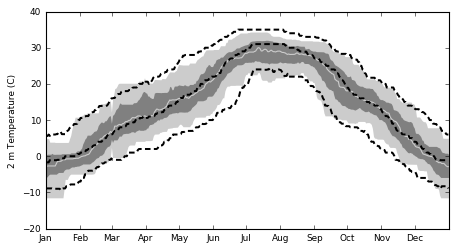

In [65]:
# Plot MesoWest Percentiles
plt.plot(MW_per['DATETIME'][hour::24],
         MW_per['p95'][hour::24],
         color='k',
         linestyle='--', dashes=(5, 3),
         label='Obs. p95')
plt.plot(MW_per['DATETIME'][hour::24],
         MW_per['p05'][hour::24],
         color='k',
         linestyle='--', dashes=(5, 3),
         label='Obs. p05')
plt.plot(MW_per['DATETIME'][hour::24],
         MW_per['p50'][hour::24],
         color='k',
         linestyle='--', dashes=(5, 3),
         label='Obs. p50')

# Plot HRRR Percentiles
plt.fill_between(DATES,
                 HTS['p95'], HTS['p05'],
                 facecolor=[.8, .8, .8],
                 linewidth=0,
                 label='HRRR p05-p95')
plt.fill_between(DATES,
                 HTS['p75'], HTS['p25'],
                 facecolor=[.5, .5, .5],
                 linewidth=0,
                 label='HRRR p25-p75')
plt.plot(DATES,
         HTS['p50'],
         color=[.8, .8, .8],
         lw=1,
         label='HRRR p50',
         zorder=1)


# Cosmetics
#legend = plt.gca().legend(frameon=True, framealpha=.5)
#legend.get_frame().set_linewidth(0)

plt.ylabel(label)
#plt.title(stn, fontweight='bold')
#plt.title('Hour of Day: %s:00 UTC' % hour, loc='left')
#plt.grid()

try:
    plt.ylim(ylim)
except:
    pass

plt.xlim([MW_per['DATETIME'][0], MW_per['DATETIME'][-1]])
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig('./figs/sandbox_Fig_07_Annual_Percentiles_%s_%s_p05p25p50p75p95_h%02d' % (stn, var.replace(':', '').replace(' ', ''), hour))

print 'Years of observed data: %.f' % (MW_per['years'][hour::24].mean())
print 'Mean Number of observations per calculation: %.f' % (MW_per['counts'][hour::24].mean())

---
## Samples in each HRRR percentile calculation
API vs. OSG file

In [66]:
# Generate the Counts from the HRRR OSG data
args = [DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, month, day, 18) for month in months for day in range(1, days[month-1]+1)]
timer = datetime.now()
COUNTS = map(get_point_COUNTS_MP, args)
p.close()
print datetime.now()-timer

0:00:00.380105


In [67]:
plt.plot(HR_per['DATETIME'][hour::24], HR_per['counts'][hour::24])
plt.plot(DATES, COUNTS, linestyle='--')

plt.gca().xaxis.set_major_formatter(formatter)

NameError: name 'HR_per' is not defined

## Samples in each MesoWest percentile Calculation

In [ ]:
plt.plot(MW_per['DATETIME'][18::24], MW_per['counts'][18::24])
plt.gca().xaxis.set_major_formatter(formatter)

In [ ]:
plt.plot(MW_per['DATETIME'][hour::24],MW_per['p50'][hour::24])

In [ ]:
HTS.keys()

In [ ]:
MW_per